<a href="https://colab.research.google.com/github/jisu1013/kaggle_practice/blob/main/Bike_Sharing_Demand_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load_data**

In [7]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#노트북 안에 그래프를 그리기 위해
%matplotlib inline
#그래프에서 마이너스 폰트가 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bike Sharing Demand/train.csv', parse_dates=["datetime"])
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bike Sharing Demand/test.csv', parse_dates=["datetime"])
train.shape,test.shape

((10886, 12), (6493, 9))

**Feature Engineering**

In [10]:
#datetime 데이터를 보기 편하도록 나눠준다
train["year"]=train["datetime"].dt.year
train["month"]=train["datetime"].dt.month
train["day"]=train["datetime"].dt.day
train["hour"]=train["datetime"].dt.hour
train["minute"]=train["datetime"].dt.minute
train["second"]=train["datetime"].dt.second
train.shape

(10886, 18)

In [11]:
#datetime 데이터를 보기 편하도록 나눠준다
test["year"]=test["datetime"].dt.year
test["month"]=test["datetime"].dt.month
test["day"]=test["datetime"].dt.day
test["hour"]=test["datetime"].dt.hour
test["minute"]=test["datetime"].dt.minute
test["second"]=test["datetime"].dt.second
test.shape

(6493, 15)

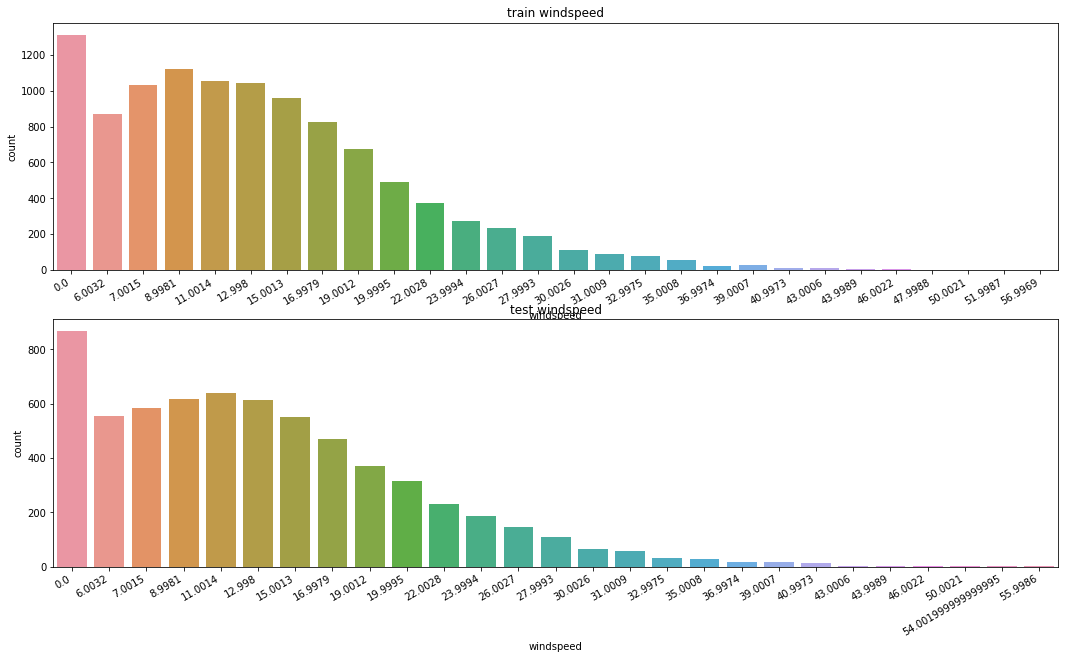

In [12]:
#sidspeed 풍속에 0 값이 가장 많다. 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30,ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])
plt.sca(axes[1])
plt.xticks(rotation=30,ha='right')
axes[1].set(ylabel='Count',title='test windspeed')
sns.countplot(data=test,x="windspeed",ax=axes[1])

In [14]:
#풍속의 0값(측정이 되지 않은 값들)에 특정 값을 넣어준다
#평균을 구해 일괄적으로 넣어줄 수 있지만, 예측의 정확도를 높이는데 도움이 되지는 않는다
#train.loc[train["windspeed"] == 0,"windspeed"]=train["windspeed"].mean()
#test.loc[test["widnspeed"] == 0],"windspeed"]=test["windspeed"].mean()

In [16]:
#풍속이 0인 것과 0이 아닌 것의 세트를 나누어 준다
trainWind0=train.loc[train['windspeed'] == 0]
trainWindNot0=train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 18)
(9573, 18)


In [19]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    #풍속이 0인 것과 아닌 것을 나눠준다
    dataWind0=data.loc[train['windspeed'] == 0]
    dataWindNot0=data.loc[train['windspeed'] != 0]
    #풍속을 예측한 피처를 선택한다.
    wCol=["season","weather","humidity","month","temp","year","atemp"]
    #풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다
    dataWindNot0["windspeed"]=dataWindNot0["windspeed"].astype("str")
    #랜덤포레스트 분류기를 사용한다
    rfModel_wind=RandomForestClassifier()
    #wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다
    rfModel_wind.fit(dataWindNot0[wCol],dataWindNot0["windspeed"])
    #학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측
    wind0Values=rfModel_wind.predict(X=dataWind0[wCol])
    
    predictionWind0=dataWind0
    predictionWindNot0=dataWindNot0
    
    predictionWind0["windspeed"]=wind0Values
    
    data=predictionWindNot0.append(predictionWind0)

    data["windspeed"]=data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)

    return data

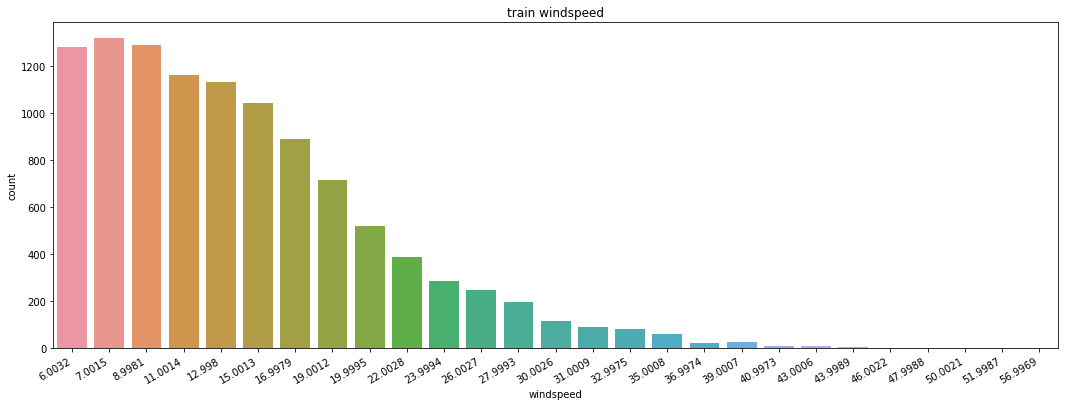

In [20]:
#0값을 조정한다
train=predict_windspeed(train)
#test=predict_windspeed(test)

#widspeed의 0값을 조정한 데이터를 시각화
fig,ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title='train windspeed')
sns.countplot(data=train, x="windspeed", ax=ax1)

**Feature Selection**
* 신호와 잡음을 구분해야 한다
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다

In [25]:
#연속형 feature와 범주형 feature
#연속형 feature=["temp","humidity","windspeed","atemp"]
#범주형 feature의 type을 category로 변경
categorical_feature_names=["season","holiday","workingday","weather",
                           "month","year","hour"]

for var in categorical_feature_names:
    train[var]=train[var].astype("category")
    test[var]=test[var].astype("category")

In [26]:
feature_names=["season","weather","temp","atemp","humidity","windspeed","year","hour","holiday","workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'holiday',
 'workingday']

In [28]:
X_train=train[feature_names]
print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,windspeed,year,hour,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,0,0


In [29]:
X_test=test[feature_names]
print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,windspeed,year,hour,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,0,1


In [30]:
label_name="count"
y_train=train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

**Score** \
**RMSLE** \
과대평가된 항목보다는 과소평가된 항목에 패널티를 준다
오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을 수록 정밀도가 높다.
0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

In [32]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    #넘파이로 배열 형태로 바꿔준다
    predicted_values=np.array(predicted_values)
    actual_values=np.array(actual_values)
    #예측값과 실제 값에 1을 더하고 로그를 씌워준다
    log_predict=np.log(predicted_values + 1)
    log_actual=np.log(actual_values+1)
    #위에서 계산한 예측값에서 실제값을 빼주고 제곱을 한다
    difference=log_predict-log_actual
    #difference=(log_predict-log_actual)**2
    difference=np.square(difference)
    #평균을 낸다
    mean_difference=difference.mean()
    #다시 루트를 씌운다
    score=np.sqrt(mean_difference)
    
    return score

rmsle_scorer=make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [33]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold=KFold(n_splits=10,shuffle=True,random_state=0)

**RandomForest**

In [34]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list=[]
model=RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [35]:
%time score=cross_val_score(model,X_train,y_train,cv=k_fold,scoring=rmsle_scorer)
score=score.mean()
#0에 근접할수록 좋은 데이터
print("Score={0:.5f}".format(score))

CPU times: user 3.26 s, sys: 649 ms, total: 3.91 s
Wall time: 28.2 s
Score=0.35222


**Train**

In [36]:
#학습시킴,fitting - feature와 lable을 넣어주면 알아서 학습함
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [37]:
#예측
predictions=model.predict(X_test)
print(predictions.shape)
predictions[0:10]

(6493,)


array([  9.62      ,   4.95      ,   4.44      ,   3.43333333,
         2.88      ,   6.72      ,  39.25      , 104.86      ,
       235.01      , 129.47      ])

[Text(0.5, 1.0, 'test')]

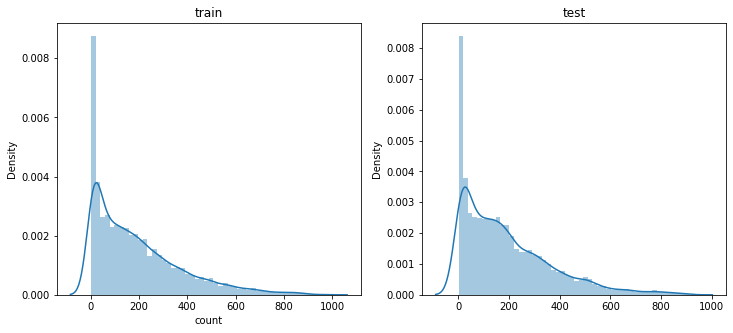

In [38]:
fig,(ax1,ax2)=plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

**Submit**

In [39]:
submission=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bike Sharing Demand/sampleSubmission.csv")
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [40]:
submission["count"]=predictions
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,9.620000
1,2011-01-20 01:00:00,4.950000
2,2011-01-20 02:00:00,4.440000
3,2011-01-20 03:00:00,3.433333
4,2011-01-20 04:00:00,2.880000


In [42]:
#점수를 파일명에 적어준다
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/Bike Sharing Demand/Score_{0:.5f}_submission.csv".format(score),index=False)